In [1]:
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.image import imread
import numpy as np

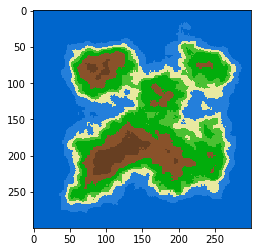

In [2]:
img = (imread('test.png')*255).astype(np.uint8)[:300, :300]
plt.imshow(img)

In [3]:
# Convert colors to tile indices
h, w, c = img.shape
tiles, tile_idx = np.unique(img.reshape(-1, c), axis=0, return_inverse=True)
tile_idx = tile_idx.reshape(h, w)
num_tiles = tiles.shape[0]

In [4]:
# Create the model and optimizers
hidden_dim = 64
model = nn.Sequential(
	# nn.BatchNorm2d(num_tiles),
	nn.Conv2d(in_channels=num_tiles, out_channels=hidden_dim, kernel_size=1),
	nn.ReLU(),
	nn.BatchNorm2d(hidden_dim),
	*[nn.Sequential(nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(hidden_dim)) for _ in range(5)],
	nn.Conv2d(in_channels=hidden_dim, out_channels=num_tiles, kernel_size=1),
)
mask_token = nn.Parameter(torch.randn(num_tiles))

optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

In [5]:
# Do the actual masking stuff and compute the loss
def mae(x:torch.Tensor, n:int=16, mask_chance:float=0.95, patch_size:int=1):
	c, h, w = x.shape
	x = x[None, :] # add batch dimension

	with torch.no_grad():
		mask = (torch.rand(n, h // patch_size, w // patch_size, device=x.device) > mask_chance).to(x.dtype)
		mask = mask.repeat_interleave(patch_size, 1).repeat_interleave(patch_size, 2).unsqueeze(1).contiguous()

	masked_x = x * mask + mask_token[None, :, None, None] * (1 - mask)
	pred_x = model(masked_x)

	loss = F.cross_entropy(pred_x, x.expand_as(pred_x).argmax(dim=1))
	# loss = (loss * (1 - mask)).sum() / ((1 - mask).sum() + 1e-5) / c
	return loss

In [6]:
# Train loop
device = 0
model = model.to(device)
mask_token = mask_token.to(device)

x = torch.eye(num_tiles)[torch.from_numpy(tile_idx).view(-1)].view(h, w, -1).permute(2, 0, 1).contiguous().to(device)
model.train()

for i in range(100):
	optim.zero_grad()
	loss = mae(x)

	print(loss.item())
	loss.backward()
	optim.step()

2.147292375564575
2.0786187648773193
1.9679226875305176
1.8440005779266357
1.712754487991333
1.5616317987442017
1.3880913257598877
1.2034952640533447
1.0344674587249756
0.8981133699417114
0.7856953144073486
0.6996752023696899
0.6313914656639099
0.5779508948326111
0.5375847816467285
0.5064978003501892
0.47756797075271606
0.45755085349082947
0.4394597113132477
0.42201176285743713
0.4100419580936432
0.39611437916755676
0.3859054744243622
0.3782937824726105
0.37400755286216736
0.3621942400932312
0.35306990146636963
0.3483164608478546
0.3433349132537842
0.33498284220695496
0.33133313059806824
0.32645493745803833
0.3258630633354187
0.32359012961387634
0.31985318660736084
0.314487487077713
0.3108344078063965
0.3083183765411377
0.3107483386993408
0.30894920229911804
0.30268898606300354
0.3018413782119751
0.30040669441223145
0.29629382491111755
0.2996898293495178
0.29548341035842896
0.2970244288444519
0.28980788588523865
0.28775227069854736
0.2911502718925476
0.2915203869342804
0.28881439566612

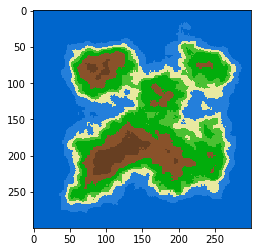

In [7]:
# Convert indices to image
def idx_to_img(x:np.ndarray):
	h, w = x.shape
	return tiles[x]
plt.imshow(idx_to_img(tile_idx))

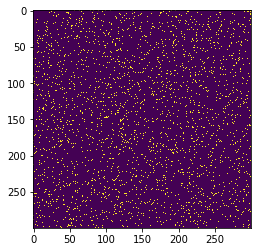

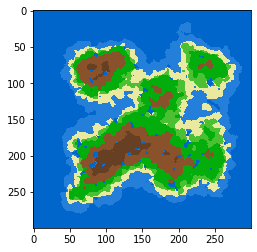

In [8]:
# Evaluate network
model.eval()

with torch.no_grad():
	patch_size = 1
	mask_chance = 0.95

	mask = (torch.rand(h // patch_size, w // patch_size, device=x.device) > mask_chance).to(x.dtype)
	mask = mask.repeat_interleave(patch_size, 0).repeat_interleave(patch_size, 1).contiguous()

	masked_x = x * mask[None, :] + mask_token[:, None, None] * (1 - mask[None, :])
	pred_x = model(masked_x[None, :])

	plt.figure()
	plt.imshow(mask.cpu().numpy())
	plt.show()
	plt.close()

	plt.figure()
	plt.imshow(idx_to_img(np.where(mask.cpu().numpy() > 0.5, tile_idx, pred_x.argmax(dim=1)[0].cpu().numpy())))
	plt.show()
	plt.close()

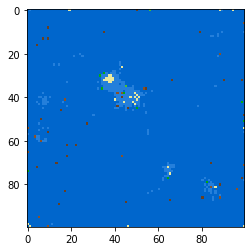

In [22]:
import itertools
import random


def funky_wunky(h, w, k=20):
	model.eval()
	
	with torch.no_grad():
		one_hot = torch.eye(num_tiles, device=device)
		img = mask_token.clone().detach()[:, None].expand(num_tiles, h*w).to(device).contiguous()
		mask = torch.ones(h*w, device=device)
		tiles_collapsed = 0

		while tiles_collapsed < h*w:
			wave = F.softmax(model(img.view(1, -1, h, w))[0], dim=0).view(-1, h*w)
			entropy = - (wave * torch.log(wave)).sum(dim=0)

			entropy_idx = torch.multinomial(F.softmax(-entropy, dim=0) * mask, num_samples=k, replacement=False)
			# entropy_idx = entropy.argsort()[tiles_collapsed:tiles_collapsed+k]
			# entropy_idx = entropy.argsort()[tiles_collapsed:]
			# entropy_idx = entropy_idx[torch.randperm(entropy_idx.numel())[:k]]
			num_samples, = entropy_idx.shape
			wave_sample = wave[:, entropy_idx]

			for i in range(num_samples):
				img[:, entropy_idx[i]] = one_hot[torch.multinomial(wave_sample[:, i], num_samples=1)[0]]
				mask[entropy_idx[i]] = 0

			tiles_collapsed += num_samples
		return img.argmax(dim=0).view(h, w).cpu().numpy()
img = funky_wunky(100, 100)
plt.imshow(idx_to_img(img))